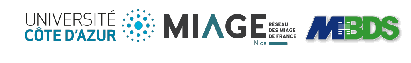

##### Deep Bridge - Nader CHATTI



# **Classification supervisée à partir des images IRM**

## Importation de l’environnement / Initialisation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
from google.colab import drive
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Chargement des données

### Accès à My Google Drive

In [2]:
drive.mount('/content/drive')

IMG_PATH = "/content/drive/My Drive/Colab Notebooks/Dataset_Brain_MRI/Supervised/"

Mounted at /content/drive


### Chargement des données

In [3]:
# Accès au dossier contenant les données
data_dir = pathlib.Path(IMG_PATH)

In [4]:
# Count des images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3022


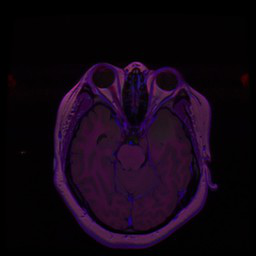

In [5]:
# Affichage d'une image sous la classe Yes
brain_Yes = list(data_dir.glob('Yes/*'))
PIL.Image.open(str(brain_Yes[0]))

### Création d'un jeu de données

In [6]:
# Paramétrage du chargeur
batch_size = 32
img_height = 128
img_width = 128

In [7]:
# Chargement des données d'entraînement
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3022 files belonging to 2 classes.
Using 2418 files for training.


In [8]:
# Chargement des données de Validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3022 files belonging to 2 classes.
Using 604 files for validation.


In [9]:
# Affichage des nom des classes
class_names = train_ds.class_names
print(class_names)

['No', 'Yes']


### Visualisation des données d'entraînement

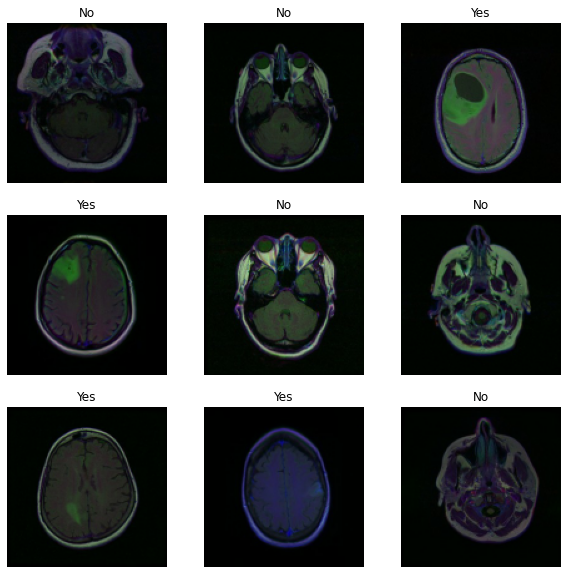

In [10]:
# Affichage des 9 premières images d'entraînement
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


## Configurations

### Configuration de l'ensemble de données pour les performances

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardisation des données

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Les valeurs de pixels sont maintenant dans l'interval `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.77647066


## Modèle

### Création du modèle

In [15]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compilation du modèle

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Résumé du modèle

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

### Formation du modèle

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
76/76 [==============================] - 147s 2s/step - loss: 0.5167 - accuracy: 0.7229 - val_loss: 0.4420 - val_accuracy: 0.7798
Epoch 2/10
76/76 [==============================] - 34s 448ms/step - loss: 0.4140 - accuracy: 0.7821 - val_loss: 0.4215 - val_accuracy: 0.7632
Epoch 3/10
76/76 [==============================] - 34s 449ms/step - loss: 0.3908 - accuracy: 0.7957 - val_loss: 0.4175 - val_accuracy: 0.7897
Epoch 4/10
76/76 [==============================] - 34s 449ms/step - loss: 0.3549 - accuracy: 0.8168 - val_loss: 0.3913 - val_accuracy: 0.7997
Epoch 5/10
76/76 [==============================] - 34s 446ms/step - loss: 0.3055 - accuracy: 0.8499 - val_loss: 0.4085 - val_accuracy: 0.8079
Epoch 6/10
76/76 [==============================] - 34s 445ms/step - loss: 0.2441 - accuracy: 0.8892 - val_loss: 0.2792 - val_accuracy: 0.8775
Epoch 7/10
76/76 [==============================] - 34s 446ms/step - loss: 0.2008 - accuracy: 0.9078 - val_loss: 0.2484 - val_accuracy: 0.8874
E

## Visualisation des résultats de l'entraînement

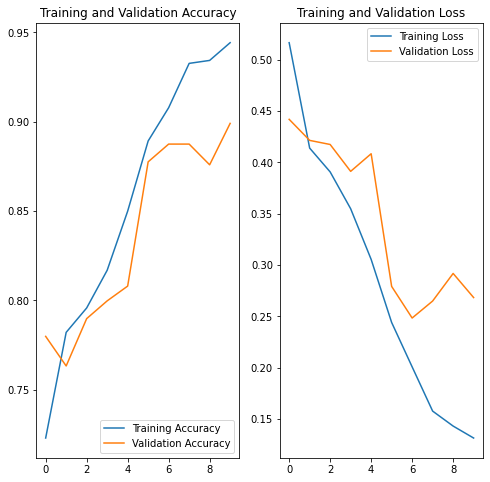

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Surapprentissage

### Augmentation des données

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

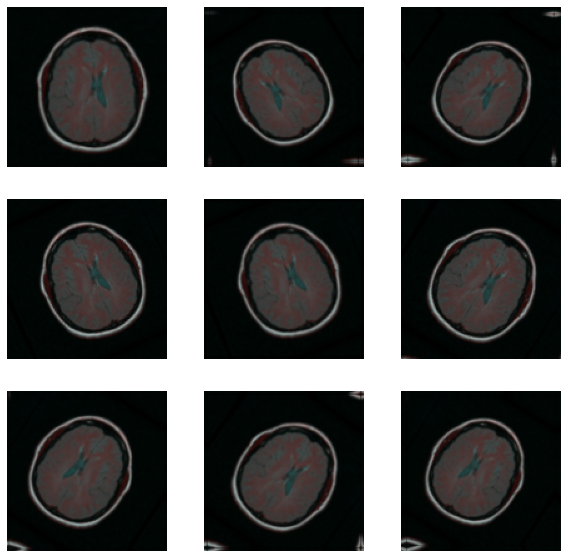

In [21]:
# Visualisons des exemples augmentés en appliquant plusieurs fois l'augmentation des données à la même image:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [22]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Modèle

### Compilation du modèle

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Résumé du modèle

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)       

### Formation du modèle

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
76/76 [==============================] - 41s 546ms/step - loss: 0.5384 - accuracy: 0.7117 - val_loss: 0.5216 - val_accuracy: 0.7351
Epoch 2/15
76/76 [==============================] - 42s 549ms/step - loss: 0.4706 - accuracy: 0.7452 - val_loss: 0.5001 - val_accuracy: 0.7831
Epoch 3/15
76/76 [==============================] - 41s 545ms/step - loss: 0.4390 - accuracy: 0.7568 - val_loss: 0.4549 - val_accuracy: 0.7864
Epoch 4/15
76/76 [==============================] - 41s 544ms/step - loss: 0.4264 - accuracy: 0.7758 - val_loss: 0.4292 - val_accuracy: 0.7914
Epoch 5/15
76/76 [==============================] - 41s 542ms/step - loss: 0.3722 - accuracy: 0.8052 - val_loss: 0.4210 - val_accuracy: 0.7914
Epoch 6/15
76/76 [==============================] - 41s 543ms/step - loss: 0.3558 - accuracy: 0.8147 - val_loss: 0.4170 - val_accuracy: 0.8046
Epoch 7/15
76/76 [==============================] - 41s 544ms/step - loss: 0.3374 - accuracy: 0.8284 - val_loss: 0.3413 - val_accuracy: 0.8212

## Visualisation des résultats de l'entraînement

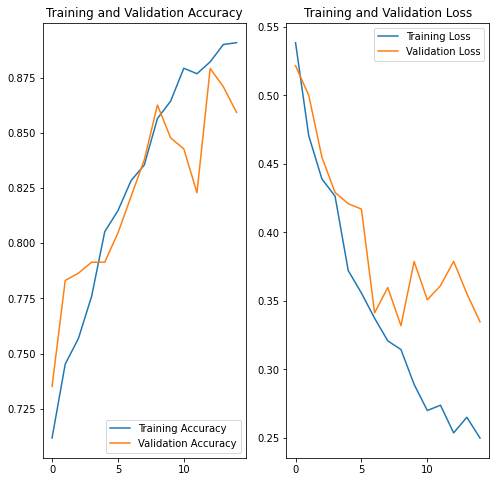

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prédiction sur de nouvelles données

Saving brain_mri_1.jpg to brain_mri_1.jpg


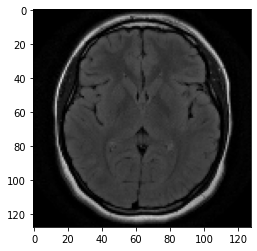

Cette image appartient probablement à << Yes >> avec << 56.08 % >> précision.


In [30]:
from google.colab import files
from io import BytesIO

uploaded = files.upload()
for fn in uploaded.keys():
       ''.format(name=fn, length=len(uploaded[fn]))

im = keras.preprocessing.image.load_img(
    fn, target_size=(img_height, img_width)
)

plt.imshow(im)
plt.show()

img_array = keras.preprocessing.image.img_to_array(im)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Cette image appartient probablement à << {} >> avec << {:.2f} % >> précision."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

!rm *.jpg